In [13]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [21]:
df = pd.read_csv("D:\Eduson_data\ds_salaries.csv", index_col=0)
# print(df.head())

 1. **Обход по группам**

In [ ]:
for name, group in df.groupby(['experience_level', 'company_size']):
    print(name)        # имя группы (tuple)
    # print(group.head())  # содержимое подтаблицы


2.**Фильтрация групп: .filter()**
* x.salary_in_usd > 400000 → булев массив (например, [False, False, True, False])

* .any() → True, если хотя бы одно значение True

In [ ]:
df.groupby('experience_level').filter(lambda x:  (x.salary_in_usd > 500000).any())

**Оставить группы, где все зарплаты не больше 400k:**


In [ ]:
df.groupby('experience_level').filter(lambda x:  (x.salary_in_usd != 400000).all())

**Оставить группы, где средняя зарплата > 400k:**

In [ ]:
df.groupby('experience_level').filter(lambda x: x.salary_in_usd.mean() > 100000)

3. **Трансформация: .transform()**

**transform** - применяет функцию к каждому элементу DataFrame или Series, возвращая результат с той же формой, что и исходные данные.
* Синтаксис: DataFrame.transform(func, axis=0, *args, **kwargs)
* Группировка зарплат по сегментам experience_level и вычисление отклонения от среднего
* .transform(lambda x: x - x.mean())→ к каждой группе применяется функция:

* x — это Series зарплат внутри одного грейда,

* x.mean() — средняя зарплата в этом грейде,

* x - x.mean() — отклонение каждой зарплаты от среднего.

In [ ]:
# Центрировать зарплату внутри каждого грейда
df['salary_centered'] = df.groupby('experience_level')['salary_in_usd'].transform(lambda x: x - x.mean())
df['salary_centered']

5. Полная статистика по каждой группе

In [ ]:
df.groupby('experience_level')['salary_in_usd'].describe()


6. Получить список групп: .groups
* Словарь -> { имя группы : [индексы]}

In [ ]:
df.groupby('experience_level').groups


7. Сохранить результат: .get_group()
* Получить конкретную подгруппу

In [ ]:
df.groupby('experience_level').get_group('SE')


8. **merge** - слияние нового столбца(результат группировки) и исходного df 
* merge() -- это как в SQL -> JOIN
спользуется, когда нужно объединить два DataFrame по общему признаку (ключу / колонке).
* concat() -- это как склеивание
Используется, когда нужно соединить DataFrames по строкам (axis=0) или по колонкам (axis=1), без ключей.

//////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [ ]:
grp = df.groupby(['experience_level'])['company_size'].sum().rename('sum_grp').reset_index()

df_1 = df.merge(grp)

df_1

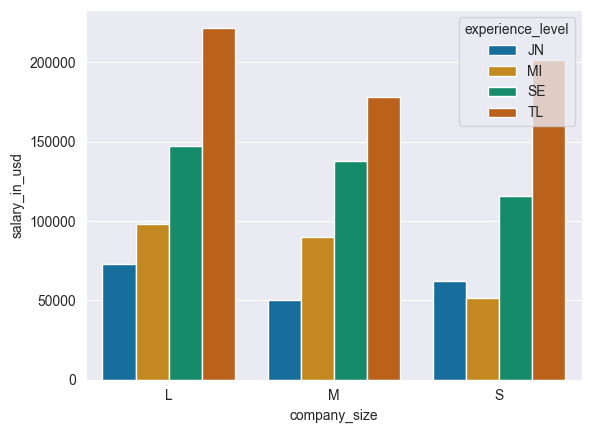

In [197]:
import seaborn as sns
import matplotlib.pyplot as plt
grp = df.groupby(['company_size', 'experience_level'])[['salary_in_usd']].mean().reset_index()
# print(grp)

sns.barplot(data=grp, x=grp.company_size, y=grp.salary_in_usd, hue=grp.experience_level, palette='colorblind')
plt.show()

In [23]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm

# Смотрим выбросы
# fig, axes = plt.subplots(figsize=(4, 2))
# sns.boxplot(x=df.salary_in_usd)
# plt.show()

# Обрезка выбросов
df_cut = df[df['salary_in_usd'] < 300000]


df_mi = df_cut[df_cut.experience_level == 'MI']
df_se = df_cut[df_cut.experience_level == 'SE']

# sns.boxplot(data=df_mi, x=df_mi.salary_in_usd, y=df_mi.company_size)
# plt.show()

# sns.boxplot(data=df_se, x=df_se.salary_in_usd, y=df_se.company_size)
# plt.show()

print('MI : p < 0.05 -> различие меж средних есть')
model_mi = ols('salary_in_usd ~ company_size', df_mi).fit()
print(anova_lm(model_mi), '\n')

print('SE: p > 0.05 -> различий меж средних нет')
model_se = ols('salary_in_usd ~ company_size', df_se).fit()
print(anova_lm(model_se))

# fig, axes = plt.subplots(figsize=(4, 2))
# sm.qqplot(model_mi.resid, line='s', ax=axes)
# plt.show()
# 
# fig, axes = plt.subplots(figsize=(4, 2))
# sm.qqplot(model_se.resid, line='s', ax=axes)
# plt.show()

tukey_mi = pairwise_tukeyhsd(endog=df_mi['salary_in_usd'], groups=df_mi['company_size'], alpha=0.05)
print(tukey_mi.summary())

tukey_se = pairwise_tukeyhsd(endog=df_se['salary_in_usd'], groups=df_se['company_size'], alpha=0.05)
print(tukey_se.summary())



MI : p < 0.05 -> различие меж средних есть
                 df        sum_sq       mean_sq         F   PR(>F)
company_size    2.0  3.459172e+10  1.729586e+10  7.931145  0.00048
Residual      207.0  4.514156e+11  2.180752e+09       NaN      NaN 

SE: p > 0.05 -> различий меж средних нет
                 df        sum_sq       mean_sq         F    PR(>F)
company_size    2.0  9.408313e+09  4.704156e+09  1.807669  0.165987
Residual      274.0  7.130390e+11  2.602332e+09       NaN       NaN
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj     lower       upper    reject
---------------------------------------------------------------
     L      M   -3590.891 0.8637 -20021.6306  12839.8485  False
     L      S -38812.1921 0.0004  -62555.647 -15068.7372   True
     M      S -35221.3011 0.0013 -58552.8591 -11889.7431   True
---------------------------------------------------------------
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     

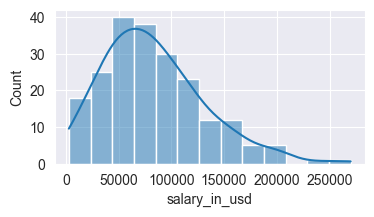

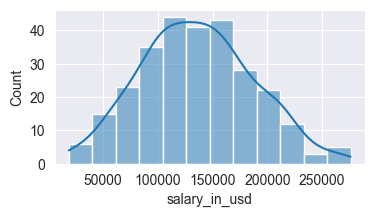

In [32]:
fig, axes = plt.subplots(figsize=(4, 2))
sns.histplot(data=df_se, x=df_mi.salary_in_usd, kde=True)
plt.show()

fig, axes = plt.subplots(figsize=(4, 2))
sns.histplot(data=df_se, x=df_se.salary_in_usd, kde=True)
plt.show()

# Pandas kind = 'bar'

    A  B
0  47  W
1  22  M
2  82  M
3  19  W
4  85  W
5  15  M
6  89  W
7  74  W
8  26  W
9  11  M


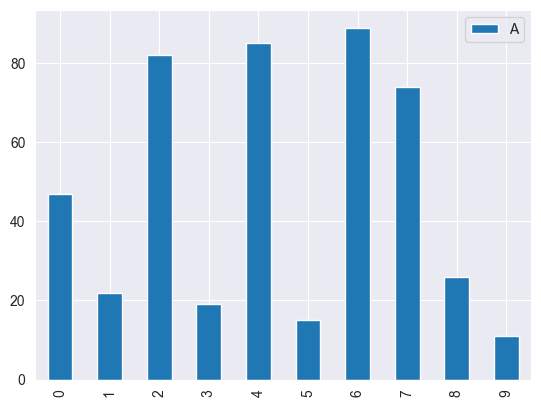

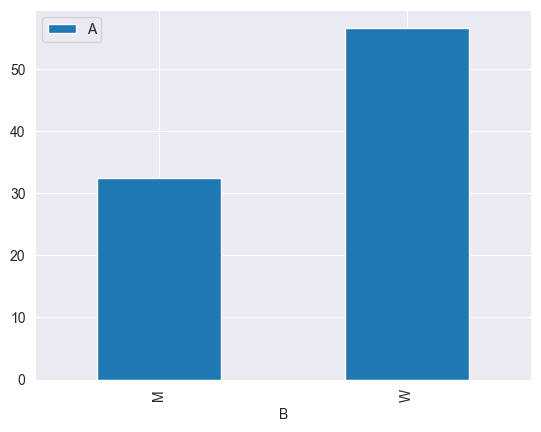

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


np.random.seed(1)
df = pd.DataFrame({'A': np.random.randint(10, 100, size=10), 
                   'B': np.where(np.random.randint(0, 2, size=10) == 1, 'M', 'W')})

print(df)

df.plot(kind ='bar')
plt.show()

df.groupby('B').mean().plot(kind ='bar')
plt.show()


# sns.barplot

   A  B
0  0  W
1  1  M
2  0  W
3  0  W
4  0  M
5  1  M
6  1  W
7  1  W
8  1  W
9  1  W


<Axes: xlabel='B', ylabel='A'>

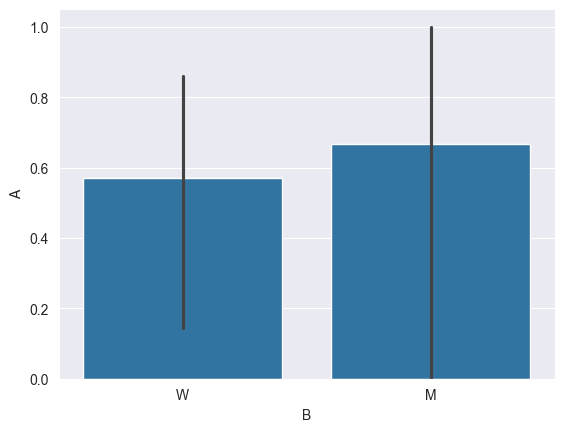

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns

np.random.seed(41)
df = pd.DataFrame({'A': np.random.randint(0, 2, size=10), 
                   'B': np.where(np.random.randint(0, 2, size=10) == 1, 'M', 'W')})

print(df)

sns.barplot(df, x=df.B, y=df.A)